# Environment

In [9]:
import os
import io
import time
import requests
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# clone the git repository and set it as the working directory
! git clone https://github.com/martin-marek/parking-space-occupancy
os.chdir('parking-space-occupancy')

Cloning into 'parking-space-occupancy'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 86 (delta 19), reused 18 (delta 18), pack-reused 60 (from 1)
Receiving objects: 100% (86/86), 3.62 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [8]:
# download the dataset
if not os.path.exists('dataset/data'):
    r = requests.get("https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2Frois_gopro.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('dataset/data')

# Visualize dataset

In [3]:
from dataset import acpds
from utils import transforms
from utils import visualize as vis

In [10]:
train_ds, valid_ds, test_ds = acpds.create_datasets('dataset/data')

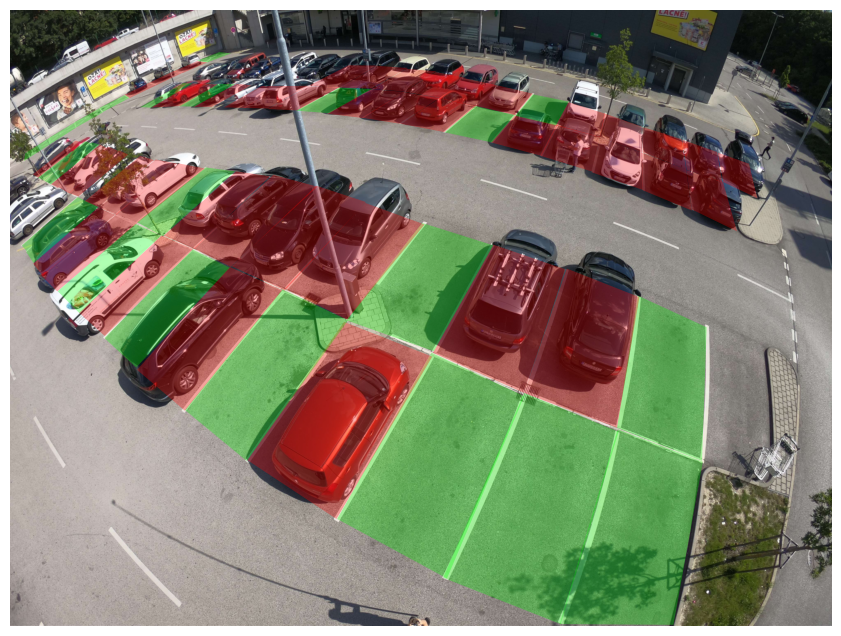

In [ ]:
image_batch, rois_batch, labels_batch = next(iter(valid_ds))
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image = transforms.preprocess(image_raw, res=1440)
vis.plot_ds_image(image, rois, labels, show=True)

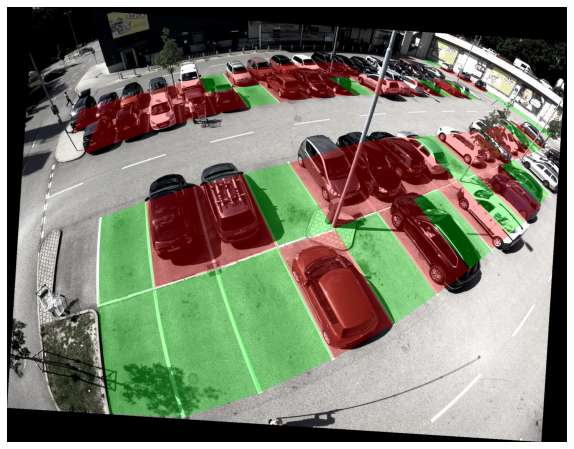

In [7]:
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image_aug, rois_aug = transforms.augment(image_raw, rois)
image_aug = transforms.preprocess(image_aug, res=1440)
vis.plot_ds_image(image_aug, rois_aug, labels, show=True)

# Plot model predictions

In [11]:
from models.faster_rcnn_fpn import FasterRCNN_FPN
model = FasterRCNN_FPN()

/home/zazza/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zazza/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zazza/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# create model
from models.rcnn import RCNN
model = RCNN()

# load model weights
weights_path = 'weights.pt'
if not os.path.exists(weights_path):
    r = requests.get('https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2FRCNN_128_square_gopro.pt')  
    with open(weights_path, 'wb') as f:
        f.write(r.content)
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

<All keys matched successfully>

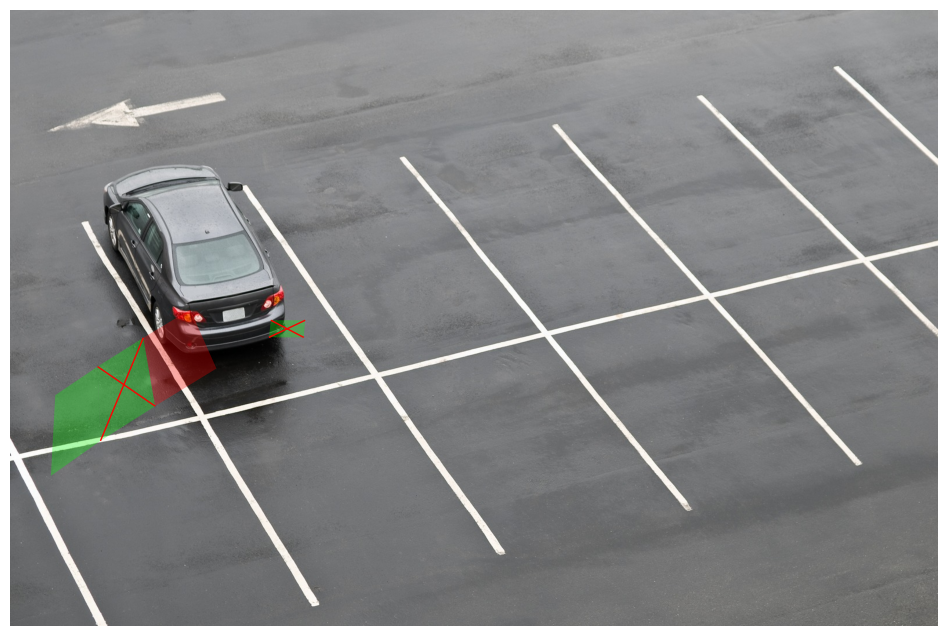

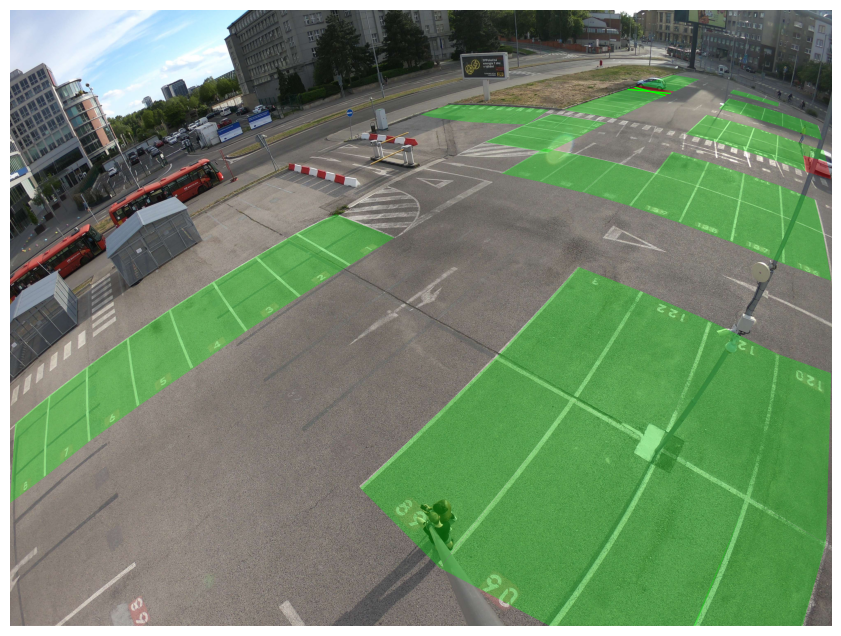

tensor([8.4738e-13, 1.1802e-12, 1.1559e-14, 1.1017e-13, 1.6176e-14, 3.6250e-15,
        4.5521e-12, 1.3361e-14, 2.2871e-14, 3.1002e-17, 4.2317e-16, 1.7428e-16,
        1.9262e-19, 2.1237e-18, 1.7720e-17, 5.0041e-13, 5.9182e-10, 8.6197e-08,
        1.4085e-08, 8.2708e-13, 3.2739e-12, 1.1192e-11, 3.3162e-09, 1.9283e-06,
        1.3122e-05, 1.4647e-08, 4.5703e-05, 1.5730e-12, 4.1431e-07, 9.5019e-07,
        1.1255e-03, 5.4750e-05, 1.2193e-12, 9.8100e-17, 3.4886e-14, 4.3224e-17,
        8.2431e-07, 8.3770e-08, 2.0623e-06, 4.7040e-05, 3.0515e-06, 1.0000e+00,
        8.1449e-02, 2.2899e-09, 6.6806e-14, 4.9152e-11, 1.1134e-13, 2.9018e-04,
        3.8905e-05, 8.8526e-06, 3.0794e-05, 1.0666e-02, 2.1300e-05, 3.9401e-02,
        1.1186e-06, 7.4648e-04, 2.2889e-04, 1.0609e-07, 2.5810e-03, 7.8941e-07,
        1.1294e-07, 3.4126e-07, 9.0431e-07, 2.4399e-06, 3.4549e-09, 4.3770e-07,
        1.0000e+00, 9.8282e-01, 3.2368e-06, 1.0177e-11, 2.5668e-02, 6.4495e-05,
        2.4708e-07, 3.2109e-02, 1.0066e-

In [14]:
# plot test predictions
for i, (image_batch, rois_batch, labels_batch) in enumerate(test_ds):
    if i == 2: break
    image, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
    image = transforms.preprocess(image)
    with torch.no_grad():
        class_logits = model(image, rois)
        class_scores = class_logits.softmax(1)[:, 1]
    vis.plot_ds_image(image, rois, class_scores, labels)    
print(class_scores)

# Plot ROI warps

In [10]:
from models.utils import pooling

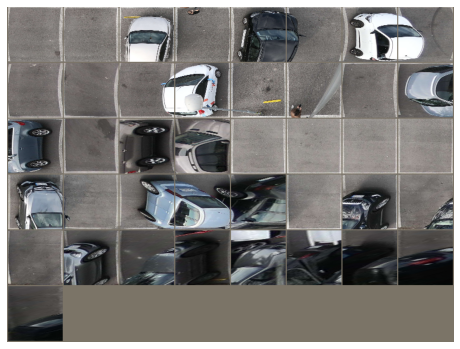

In [11]:
warps = pooling.roi_pool(image, rois, 100, 'qdrl')
vis.show_warps(warps)

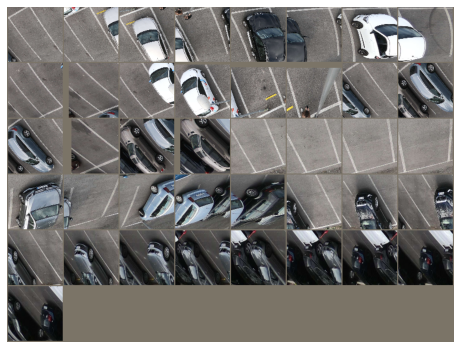

In [12]:
warps = pooling.roi_pool(image, rois, 100, 'square')
vis.show_warps(warps)

# Speed comparison

In [ ]:
from models.rcnn import RCNN
from models.faster_rcnn_fpn import FasterRCNN_FPN

In [ ]:
def time_model(model, res=[1920, 1440], n=3):
    image = torch.zeros([3, res[1], res[0]])
    L_arr = torch.linspace(1, 100, steps=10, dtype=torch.int32)
    mean = np.zeros_like(L_arr, dtype=np.float32)
    ese = np.zeros_like(L_arr, dtype=np.float32)
    for i, L in enumerate(L_arr):
        times = np.zeros(n)
        for j in range(n):
            rois = torch.rand([L, 4, 2])
            t0 = time.time()
            out = model(image, rois)
            t1 = time.time()
            times[j] = t1 - t0
        mean[i] = np.mean(times)
        ese[i] = np.std(times) / np.sqrt(len(times))
    return L_arr, mean, ese

In [ ]:
times = {}
times['R-CNN (64)']  = time_model(RCNN(roi_res=64),  res=[4000, 3000])
times['R-CNN (128)'] = time_model(RCNN(roi_res=128), res=[4000, 3000])
times['R-CNN (256)'] = time_model(RCNN(roi_res=256), res=[4000, 3000])
times['Faster R-CNN FPN (800)']   = time_model(FasterRCNN_FPN(), res=[1067, 800])
times['Faster R-CNN FPN (1100)']  = time_model(FasterRCNN_FPN(), res=[1467, 1100])
times['Faster R-CNN FPN (1440)']  = time_model(FasterRCNN_FPN(), res=[1920, 1440])

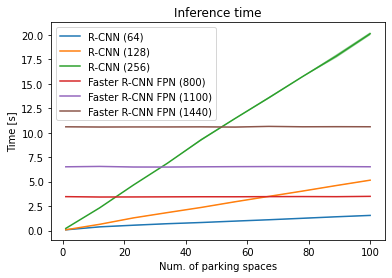

In [ ]:
for k, v in times.items():
    plt.plot(v[0], v[1], label=k)
    plt.fill_between(v[0], v[1]-v[2], v[1]+v[2], alpha=0.5)

plt.title('Inference time')
plt.xlabel('Num. of parking spaces')
plt.ylabel('Time [s]')
plt.legend()
plt.show()

# FPN level resolutions

In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
backbone = resnet_fpn_backbone('resnet50', pretrained=False)
image = torch.zeros([3, 1920, 1440])
out = backbone.body(image[None])
for k, v in out.items():
    print(k, v.shape)

0 torch.Size([1, 256, 480, 360])
1 torch.Size([1, 512, 240, 180])
2 torch.Size([1, 1024, 120, 90])
3 torch.Size([1, 2048, 60, 45])
